In [1]:
import numpy as np

In [146]:
mu_earth = 398600.4418  # km^3/s^2
mu_moon = 4902.8  # km^3/s^2
T = 27.32 * 24 * 60 * 60  # in seconds
R = 384400  # km

def vector_moon(t):
    return np.array([R*np.cos(2*np.pi/T*t), R*np.sin(2*np.pi/T*t), 0])

def cislunar_gravity(r_craft, t):
    r_craft_moon = r_craft - vector_moon(t)
    moon_influence = -(r_craft_moon * mu_moon) / np.linalg.norm(r_craft_moon)**3
    earth_influence = -r_craft * mu_earth / np.linalg.norm(r_craft)**3
    return moon_influence + earth_influence

def degree_angle(A, B) -> float:
    """Double check"""
    cos_theta = np.dot(A,B) / (np.linalg.norm(A) * np.linalg.norm(B))
    angle = np.arccos(cos_theta)
    return np.degrees(angle)

def is_visible(r_sensor, r_target) -> bool:
    # constant
    max_range = 2000

    distance = np.linalg.norm(r_sensor - r_target)
    angle = degree_angle(r_sensor, r_target)
    if distance > max_range or angle > 40:
        return False
    return True

def vector_sensor(t):
    r_sensor_moon = np.array([0, 0, -1736])
    return vector_moon(t) + r_sensor_moon


In [217]:
# initial state: set relative to Earth
pos_craft = np.array([325.59, 446.71, 1791.67]) + vector_moon(0)
v_craft = np.array([-1.78, 0.08, 0.3]) + (vector_moon(1) - vector_moon(0))

# simulation
history = []
for t in range(1, 86400+1):
    a_craft = cislunar_gravity(pos_craft, t)
    v_craft = v_craft + a_craft  # update velocity
    pos_craft = pos_craft + v_craft # Update position
    pos_sensor = vector_sensor(t)
    pos_moon = vector_moon(t)
    vis = is_visible(pos_sensor, pos_craft)
    angle = degree_angle(pos_sensor, pos_craft)
    history.append({'moon': pos_moon,
                    'sensor': pos_sensor,
                    'craft': pos_craft,
                    'angle': angle,
                    'isVisible': vis,
                    'acceleration': a_craft,
                    'velocity': v_craft})


Plotting (Sanity Check)

In [162]:
import matplotlib.pyplot as plt

In [223]:
# extract data
moon = np.array([event['moon'] for event in history])
sensor_good = np.array([event['sensor'] for event in history if event['isVisible']])
sensor_bad = np.array([event['sensor'] for event in history if not event['isVisible']])
craft_good = np.array([event['craft'] for event in history if event['isVisible']])
craft_bad = np.array([event['craft'] for event in history if not event['isVisible']])

14

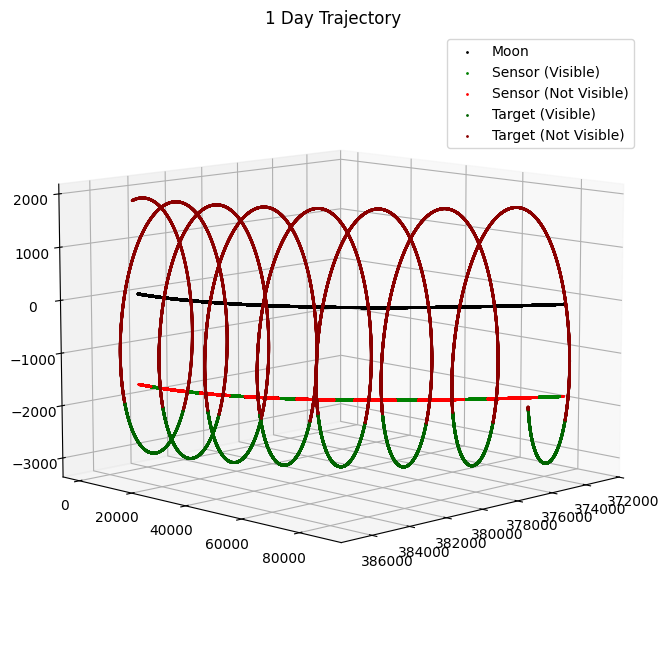

In [230]:
# process data
moon_x = moon[:, 0]
moon_y = moon[:, 1]
moon_z = moon[:, 2]
sensor_g_x = sensor_good[:, 0]
sensor_g_y = sensor_good[:, 1]
sensor_g_z = sensor_good[:, 2]
sensor_b_x = sensor_bad[:, 0]
sensor_b_y = sensor_bad[:, 1]
sensor_b_z = sensor_bad[:, 2]
craft_g_x = craft_good[:, 0]
craft_g_y = craft_good[:, 1]
craft_g_z = craft_good[:, 2]
craft_b_x = craft_bad[:, 0]
craft_b_y = craft_bad[:, 1]
craft_b_z = craft_bad[:, 2]

# Plot the points
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(moon_x, moon_y, moon_z, c='black', marker='o', s=1)
ax.scatter(sensor_g_x, sensor_g_y, sensor_g_z, c='g', marker='o', s=1)
ax.scatter(sensor_b_x, sensor_b_y, sensor_b_z, c='r', marker='o', s=1)
ax.scatter(craft_g_x, craft_g_y, craft_g_z, c='darkgreen', marker='o', s=1)
ax.scatter(craft_b_x, craft_b_y, craft_b_z, c='darkred', marker='o', s=1)

ax.set_title('1 Day Trajectory')
ax.legend(["Moon", "Sensor (Visible)", "Sensor (Not Visible)", "Target (Visible)", "Target (Not Visible)"])

ax.view_init(elev=10, azim=45)

def rotate(event):
    if event.inaxes == ax:
        ax.view_init(elev=ax.elev, azim=ax.azim)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', rotate)

Final Answer

In [235]:
visible = np.array([event['isVisible'] for event in history])
percent_visible = sum(visible)/86400*100
print(f"Percentage of the time target will be visible: {round(percent_visible, 1)}%")

Percentage of the time target will be visible: 35.9%


In [238]:
def avg_gap(sequence):
    cycle_count = 0
    gap_count = 0
    curr_duration = 0
    for vis in sequence:
        if not vis:
            curr_duration += 1
        else:
            if curr_duration > 0:
                gap_count += curr_duration
                cycle_count += 1
                curr_duration = 0
    if curr_duration > 0:
        cycle_count += 1
        gap_count += curr_duration
    return gap_count / cycle_count

avg_gap_sec = avg_gap(visible)
avg_gap_min = avg_gap_sec/60
print(f"Average duration of gaps in observation: {round(avg_gap_min, 1)} minutes")

Average duration of gaps in observation: 102.6 minutes
